In [190]:
from random import randint, random, choice
from scipy.stats import norm

number_of_levers = 10
initial_lever_rewards = [randint(0, 50) for _ in range(number_of_levers)]

reward_estimates = [np.empty(number_of_steps + 1) for _ in range(number_of_levers)]

for lever in range(number_of_levers):
    reward_estimates[lever][0] = 25

learning_rate = 0.1
explore_rate = 2
number_of_steps = 10000
reward_mean_noise_stddev = 0.5
noise_distribution = norm(0, reward_mean_noise_stddev)
#noisy_lever_rewards = [initial_lever_rewards[lever] + np.cumsum(noise_distribution.rvs(number_of_steps)) for lever in range(number_of_levers)]
noisy_lever_rewards = [initial_lever_rewards[lever] + noise_distribution.rvs(number_of_steps) for lever in range(number_of_levers)]
rewards = np.empty(number_of_steps)

def choose_lever_explore_exploit(step):
    if random() < explore_rate:
        return randint(0, number_of_levers - 1)
    else:
        best_lever = None
        best_reward = -1
        
        for lever in range(number_of_levers):
            if reward_estimates[lever][step] > best_reward:
                best_lever = lever
                best_reward = reward_estimates[lever][step]
            elif reward_estimates[lever][step] == best_reward and random() > 0.5:
                best_lever = lever

        return best_lever

number_of_times_lever_chosen = number_of_levers * [0]
    
def choose_lever_upper_confidence_bound(step):
    best_value = -1
    best_levers = []
    new_levers = []
    
    for lever in range(number_of_levers):
        if step == 0 or number_of_times_lever_chosen[lever] == 0:
            new_levers.append(lever)
            continue
        
        value = reward_estimates[lever][step] + explore_rate * np.sqrt(np.log(step) / number_of_times_lever_chosen[lever])
        
        if value > best_value:
            best_value = value
            best_levers = [lever]
        elif value == best_value:
            best_levers.append(lever)
    
    chosen_lever = choice(best_levers + new_levers)
    number_of_times_lever_chosen[chosen_lever] += 1
    return chosen_lever
    
for step in range(number_of_steps):
    chosen_lever = choose_lever_upper_confidence_bound(step)
    reward = noisy_lever_rewards[chosen_lever][step]
    rewards[step] = reward
    
    for lever in range(number_of_levers):
        if lever == chosen_lever:
            reward_estimates[lever][step + 1] = learning_rate * reward + (1 - learning_rate) * reward_estimates[lever][step]
        else:
            reward_estimates[lever][step + 1] = reward_estimates[lever][step]

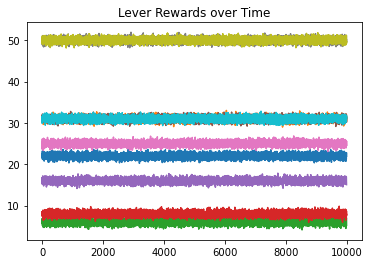

In [191]:
from matplotlib import pyplot as plt
plt.figure()
plt.title('Lever Rewards over Time')
for lever in range(number_of_levers):
    plt.plot(noisy_lever_rewards[lever])

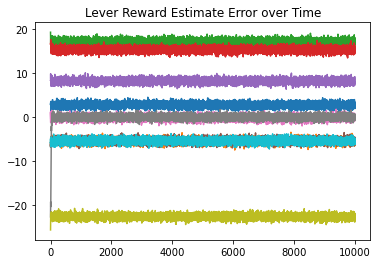

In [192]:
plt.figure()
plt.title('Lever Reward Estimate Error over Time')
for lever in range(number_of_levers):
    plt.plot(reward_estimates[lever][1:] - noisy_lever_rewards[lever])

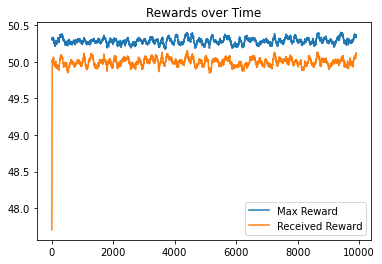

In [193]:
window_size = 100

max_rewards = np.empty(number_of_steps)

for step in range(number_of_steps):
    max_rewards[step] = max([noisy_lever_rewards[lever][step] for lever in range(number_of_levers)])

filtered_max_rewards = np.convolve(max_rewards, np.ones(window_size) / window_size, 'valid')
filtered_rewards = np.convolve(rewards, np.ones(window_size) / window_size, 'valid')

plt.figure()
plt.title('Rewards over Time')
plt.plot(filtered_max_rewards)
plt.plot(filtered_rewards)
plt.legend(['Max Reward', 'Received Reward'])
plt.show()